<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/CHIME_FRB_Waterfall_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use this tutorial:

https://chime-frb-open-data.github.io/waterfall/

data are available here:

https://www.canfar.net/storage/vault/list/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data

In [44]:
#Import Librarys
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
import io
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure
import h5py
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import gridspec


In [59]:
files = ['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701E_waterfall.h5',
#  #'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701D_waterfall.h5',
#  'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701C_waterfall.h5',
#  'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701B_waterfall.h5',
#  'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701A_waterfall.h5',
#  'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190630D_waterfall.h5'
]

In [60]:
!gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701E_waterfall.h5"
#!gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701D_waterfall.h5"
# !gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701C_waterfall.h5"
# !gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701B_waterfall.h5"
# !gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701A_waterfall.h5"
# !gdown "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190630D_waterfall.h5"

Downloading...
From: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/AstroDataCitationDOI/CISTI.CANFAR/21.0007/data/waterfalls/data/FRB20190701E_waterfall.h5
To: /content/FRB20190701E_waterfall.h5
100% 35.5M/35.5M [00:03<00:00, 11.3MB/s]


In [61]:
names, file_name = [],[]
for i in range(len(files)): 
  names.append(files[i][-25:-13])
  file_name.append(files[i][-25:])

In [62]:
df = pd.DataFrame()
for i in range(len(names)):
  data = h5py.File(file_name[i], "r")

In [63]:
list(data['frb'].keys())

['calibrated_wfall',
 'extent',
 'model_spec',
 'model_ts',
 'model_wfall',
 'plot_freq',
 'plot_time',
 'spec',
 'ts',
 'wfall']

# Unpack the Data

In [64]:
#data            = data["frb"]
eventname       = data.attrs["tns_name"].decode()
wfall           = data["wfall"][:]
model_wfall     = data["model_wfall"][:]
plot_time       = data["plot_time"][:]
plot_freq       = data["plot_freq"][:]
ts              = data["ts"][:]
model_ts        = data["model_ts"][:]
spec            = data["spec"][:]
model_spec      = data["model_spec"][:]
extent          = data["extent"][:]
dm              = data.attrs["dm"][()]
scatterfit = data.attrs["scatterfit"][()]
cal_obs_date    = data.attrs["calibration_observation_date"].decode()
cal_source_name = data.attrs["calibration_source_name"].decode()
cal_wfall       =  data["calibrated_wfall"][:]


dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 

KeyError: ignored

# RFI Removal

In [65]:
q1 = np.nanquantile(spec, 0.25)
q3 = np.nanquantile(spec, 0.75)
iqr = q3 - q1

# additional masking of channels with RFI
rfi_masking_var_factor = 3

channel_variance = np.nanvar(wfall, axis=1)
mean_channel_variance = np.nanmean(channel_variance)

with np.errstate(invalid="ignore"):
    rfi_mask = (channel_variance > \
                rfi_masking_var_factor * mean_channel_variance) \
                | (spec[::-1] < q1 - 1.5 * iqr) | (spec[::-1] > q3 + 1.5 * iqr)
wfall[rfi_mask,...] = np.nan
model_wfall[rfi_mask,...] = np.nan
spec[rfi_mask[::-1]] = np.nan

# remake time-series after RFI masking
ts = np.nansum(wfall, axis=0)
model_ts = np.nansum(model_wfall, axis=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


# Pulse Properties



In [66]:
def boxcar_kernel(width):
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, min_width=1, max_width=128):
    min_width = int(min_width)
    max_width = int(max_width)
    # do not search widths bigger than timeseries
    widths = list(range(min_width, min(max_width + 1, len(ts)-2)))
    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)
    for i in range(len(widths)):
        convolved = scipy.signal.convolve(ts, boxcar_kernel(widths[i]), mode="same")
        peaks[i] = np.nanargmax(convolved)
        snrs[i] = convolved[peaks[i]]
    best_idx = np.nanargmax(snrs)
    return peaks[best_idx], widths[best_idx], snrs[best_idx]


# Pulse Properties

In [67]:
def boxcar_kernel(width):
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, min_width=1, max_width=128):
    min_width = int(min_width)
    max_width = int(max_width)
    # do not search widths bigger than timeseries
    widths = list(range(min_width, min(max_width + 1, len(ts)-2)))
    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)
    for i in range(len(widths)):
        convolved = scipy.signal.convolve(ts, boxcar_kernel(widths[i]), mode="same")
        peaks[i] = np.nanargmax(convolved)
        snrs[i] = convolved[peaks[i]]
    best_idx = np.nanargmax(snrs)
    return peaks[best_idx], widths[best_idx], snrs[best_idx]


In [68]:
peak, width, snr = find_burst(ts)
print(f"Peak: {peak} at time sample, Width = {width*dt} ms, SNR = {snr}")


Peak: 13 at time sample, Width = 1.9660799880512059 ms, SNR = 143.76201243143078


# Bin Frequency Data

In [69]:
def bin_freq_channels(data, fbin_factor=4):
    num_chan = data.shape[0]
    if num_chan % fbin_factor != 0:
        raise ValueError("frequency binning factor `fbin_factor` should be even")
    data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)
    return data


In [70]:
# bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
wfall = bin_freq_channels(wfall, 16)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


# Plot the Dynamic Spectrum

Text(0.5, 0, 'Time [ms]')

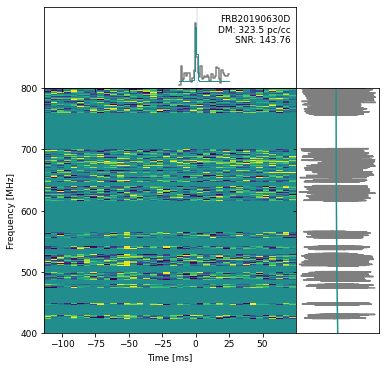

In [71]:
fig = plt.figure(figsize=(6,6))
## Set up the image grid
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[3, 1],
                        height_ratios=[1, 3], hspace=0.0, wspace=0.0)
data_im = plt.subplot(gs[2])
data_ts = plt.subplot(gs[0], sharex=data_im)
data_spec = plt.subplot(gs[3], sharey=data_im)


### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = extent[0] - plot_time[peak_idx]
extent[1] = extent[1] - plot_time[peak_idx]
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)

cmap = plt.cm.viridis

### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

data_im.imshow(wfall, aspect="auto", interpolation="none",
                extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)

### plot time-series
data_ts.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post")

### plot spectrum
data_spec.plot(spec, plot_freq, color="tab:gray")

### plot model time-series and spectrum
if scatterfit:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.25))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2)
else:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.5))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1)


## BEautify plot
# remove some labels and ticks for neatness
plt.setp(data_ts.get_xticklabels(), visible=False)
data_ts.set_yticklabels([], visible=True)
data_ts.set_yticks([])
data_ts.set_xlim(extent[0], extent[1])
plt.setp(data_spec.get_yticklabels(), visible=False)
data_spec.set_xticklabels([], visible=True)
data_spec.set_xticks([])
data_spec.set_ylim(extent[2], extent[3])
plt.setp(data_im.get_xticklabels(), fontsize=9)
plt.setp(data_im.get_yticklabels(), fontsize=9)


#### highlighting the width of the pulse
data_ts.axvspan(max(plot_time.min(),
                        plot_time[peak] + 0.5 * dt \
                        - (0.5 * width) * dt),
                    min(plot_time.max(),
                        plot_time[peak] + 0.5 * dt \
                        + (0.5 * width) * dt),
                    facecolor="tab:blue", edgecolor=None, alpha=0.1)


##### add event ID and DM labels
xlim = data_ts.get_xlim()
ylim = data_ts.get_ylim()

# add 20% extra white space at the top
span = np.abs(ylim[1]) + np.abs(ylim[0])
data_ts.set_ylim(ylim[0], ylim[1] + 0.2 * span)
ylim = data_ts.get_ylim()

ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
xpos = (xlim[1] - xlim[0]) * 0.98 + extent[0]
data_ts.text(xpos, ypos, "{}\nDM: {:.1f} pc/cc\nSNR: {:.2f}".format(eventname, dm,snr), ha="right",
                va="top", fontsize=9)

data_im.locator_params(axis="x", min_n_ticks=3)
data_im.set_yticks([400, 500, 600, 700, 800])
data_im.set_ylabel("Frequency [MHz]", fontsize=9)
data_im.set_xlabel("Time [ms]", fontsize=9)


#Plotting Calibrated Data

In [72]:
cal_ts = np.nanmean(cal_wfall, axis = 0)


In [73]:
cal_wfall[np.isnan(cal_wfall)] = np.nanmedian(cal_wfall)   # replace nans in the data with the data median
#bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
cal_wfall = bin_freq_channels(cal_wfall,16) 
vmin = np.nanpercentile(cal_wfall, 1)
vmax = np.nanpercentile(cal_wfall, 99)

times = np.arange(len(cal_ts))*dt
peak_idx = np.argmax(cal_ts)
times -= times[peak_idx]
times -= dt / 2.

extent[0] = times[0]
extent[1] = times[-1]



Text(0, 0.5, 'Flux [Jy]')

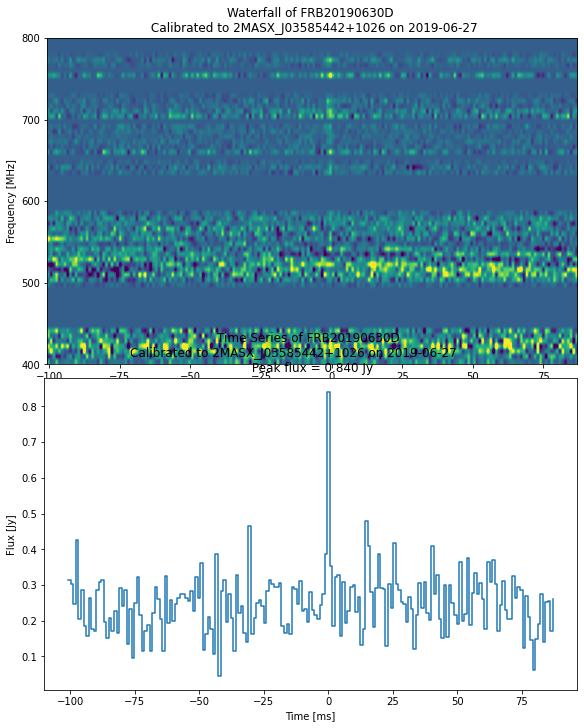

In [74]:
fig = plt.figure(figsize=(8,10), constrained_layout=True)
layout = """
A
C
"""
plt.subplot(2,1,1)
plt.imshow(cal_wfall, aspect="auto", vmin=vmin,vmax=vmax, extent = extent )
plt.title(f"Waterfall of {eventname} \n Calibrated to {cal_source_name} on {cal_obs_date}")
plt.yticks([400, 500, 600, 700, 800])
plt.ylabel("Frequency [MHz]")


plt.subplot(2,1,2)

plt.plot(times,cal_ts, drawstyle="steps-post")
plt.xlabel("Time [ms]")
plt.title(f"Time Series of {eventname} \nCalibrated to {cal_source_name} on {cal_obs_date} \
        \n Peak flux = {cal_ts[peak_idx]:.3f} Jy")
plt.ylabel("Flux [Jy]")
